# Building an Image Caption Generator using CNN-LSTM from Scratch
**Deep Learning for Electrical & Computer Engineers**

**EC9170**

**Mini Project**

Group Members :


*   2021/E/010

*   2021/E/146

*   2021/E/185

## References

1. Implementing Image Captioning with CNN-LSTM from Scratch  
   https://towardsdatascience.com/image-caption-generator-using-cnn-and-lstm-in-pytorch-7c52f0134e7c

2. How to Generate Text from Image Features using LSTM  
   https://machinelearningmastery.com/develop-a-deep-learning-caption-generation-model-in-python/

3. Keras Embedding and LSTM Layers Documentation  
   https://keras.io/api/layers/core_layers/embedding/  
   https://keras.io/api/layers/recurrent_layers/lstm/

4. BLEU Score Explained – Wikipedia  
   https://en.wikipedia.org/wiki/BLEU

5. Text Tokenization and Padding with Keras  
   https://keras.io/api/preprocessing/text/


# Introduction

This notebook represents the second and most critical stage of the project: **generating textual captions for images using a CNN-LSTM architecture**.

Here, the goal is to build a sequence generation model that takes in image features (obtained from our custom CNN) and outputs descriptive natural language captions.

### What this notebook includes:
- Preprocessing the textual captions (tokenization, padding).
- Designing an LSTM-based decoder model.
- Training the CNN-LSTM model on image-caption pairs.
- Generating captions using greedy decoding.
- Evaluating model performance using metrics like BLEU score.

The model is trained **from scratch**, offering full control over both the visual and language components. This demonstrates how deep learning models can learn to associate visual features with sequential linguistic patterns.



In [ ]:
# Import Libraries

import os
import string
import numpy as np
import pandas as pd
from PIL import Image
from tqdm.notebook import tqdm
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras.preprocessing.image import load_img, img_to_array
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LSTM, Embedding, Dropout, add



In [ ]:
# Load Data
# Mount Google Drive (if using Colab)
from google.colab import drive
drive.mount('/content/drive')

# Define paths - UPDATE THESE TO MATCH YOUR ACTUAL PATHS
base_path = '/content/drive/MyDrive/OneDrive_1_3-12-2025/'
images_folder = os.path.join(base_path, 'Images')
captions_file = os.path.join(base_path, 'captions.txt')


# Verify the paths
print(f"Images Folder Path: {images_folder}")
print(f"Captions File Path: {captions_file}")


Mounted at /content/drive
Images Folder Path: /content/drive/MyDrive/OneDrive_1_3-12-2025/Images
Captions File Path: /content/drive/MyDrive/OneDrive_1_3-12-2025/captions.txt


In [ ]:
# Check if it lists any image files from your folder
sample_images = os.listdir(images_folder)

print(f"Number of images found: {len(sample_images)}")
print(f"First 5 image file names: {sample_images[:5]}")


Number of images found: 8126
First 5 image file names: ['523991446_65dbc5a4a5.jpg', '531055369_936fd76a63.jpg', '61209225_8512e1dad5.jpg', '576093768_e78f91c176.jpg', '551664516_78a5131dc4.jpg']


In [ ]:
import pandas as pd
import os

# Define the full path to your captions file using the base_path
captions_file_path = os.path.join(base_path, 'captions.txt')

# Read the captions file using the full path
captions_df = pd.read_csv(captions_file_path)

# Show the first few rows
captions_df.head()

,image,caption
0,1000268201_693b08cb0e.jpg,A child in a pink dress is climbing up a set o...
1,1000268201_693b08cb0e.jpg,A girl going into a wooden building .
2,1000268201_693b08cb0e.jpg,A little girl climbing into a wooden playhouse .
3,1000268201_693b08cb0e.jpg,A little girl climbing the stairs to her playh...
4,1000268201_693b08cb0e.jpg,A little girl in a pink dress going into a woo...


In [ ]:
# Create a dictionary: image_id -> list of captions
image_captions = {}

# Group captions by image
for image_id, caption in captions_df.values:  # iterate over the rows
    if image_id not in image_captions:
        image_captions[image_id] = []
    image_captions[image_id].append(caption)

# Check one sample image and its captions
sample_image_id = list(image_captions.keys())[3]
print(f"Image ID: {sample_image_id}")
print("Captions:")
for cap in image_captions[sample_image_id]:
    print(f"- {cap}")


Image ID: 1003163366_44323f5815.jpg
Captions:
- A man lays on a bench while his dog sits by him .
- A man lays on the bench to which a white dog is also tied .
- a man sleeping on a bench outside with a white and black dog sitting next to him .
- A shirtless man lies on a park bench with his dog .
- man laying on bench holding leash of dog sitting on ground


Searching for images in: /content/drive/MyDrive/OneDrive_1_3-12-2025/Images
Found image: /content/drive/MyDrive/OneDrive_1_3-12-2025/Images/1003163366_44323f5815.jpg


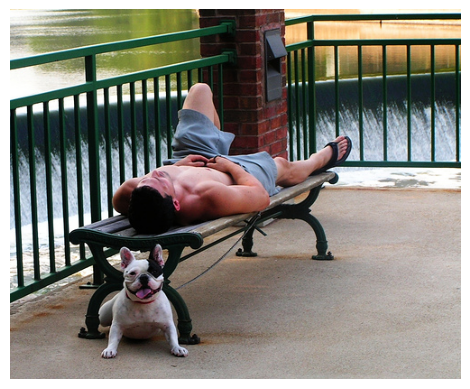

In [ ]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Update the path to your images folder
images_folder = '/content/drive/MyDrive/OneDrive_1_3-12-2025/Images'  # Replace with your path

# Verify the path
print(f"Searching for images in: {images_folder}")

# Pick a sample image id
sample_image_id = list(image_captions.keys())[3]

# Build the full path
sample_image_path = os.path.join(images_folder, sample_image_id)

# Verify and display image
if os.path.exists(sample_image_path):
    print(f"Found image: {sample_image_path}")
    img = Image.open(sample_image_path)
    plt.imshow(img)
    plt.axis('off')
    plt.show()
else:
    print(f"Image not found: {sample_image_path}")

In [ ]:
import string

# Function to clean the captions
def preprocess_caption(caption):
    # Convert to lowercase
    caption = caption.lower()

    # Remove punctuation
    caption = caption.translate(str.maketrans('', '', string.punctuation))

    # Remove digits and extra spaces (optional)
    caption = ' '.join(caption.split())

    # Add <start> and <end> tokens
    caption = '<start> ' + caption + ' <end>'

    return caption


In [ ]:
# Create a new dictionary for cleaned captions
cleaned_captions = {}

for image_id, captions_list in image_captions.items():
    cleaned_captions[image_id] = [preprocess_caption(caption) for caption in captions_list]

# Check one sample
sample_image_id = list(cleaned_captions.keys())[3]
print(f"Image ID: {sample_image_id}")
print("Cleaned Captions:")
for cap in cleaned_captions[sample_image_id]:
    print(f"- {cap}")


Image ID: 1003163366_44323f5815.jpg
Cleaned Captions:
- <start> a man lays on a bench while his dog sits by him <end>
- <start> a man lays on the bench to which a white dog is also tied <end>
- <start> a man sleeping on a bench outside with a white and black dog sitting next to him <end>
- <start> a shirtless man lies on a park bench with his dog <end>
- <start> man laying on bench holding leash of dog sitting on ground <end>


In [ ]:
# Collect all the captions into a single list
all_captions = []

for captions_list in cleaned_captions.values():
    all_captions.extend(captions_list)

# Sanity check
print(f"Total cleaned captions: {len(all_captions)}")
print("First 3 captions:")
for cap in all_captions[:3]:
    print(cap)


Total cleaned captions: 40455
First 3 captions:
<start> a child in a pink dress is climbing up a set of stairs in an entry way <end>
<start> a girl going into a wooden building <end>
<start> a little girl climbing into a wooden playhouse <end>


In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer

# Define the maximum number of words to keep (optional: for limiting vocab)
vocab_size = 5000  # Start with this. You can later increase if you want ALL words.

# Initialize tokenizer
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<unk>")  # oov_token for out-of-vocabulary words

# Fit tokenizer on all captions
tokenizer.fit_on_texts(all_captions)

# Save important info
total_words_in_tokenizer = len(tokenizer.word_index) + 1  # add 1 for padding
print(f"Total words found in tokenizer (word_index): {total_words_in_tokenizer}")


Total words found in tokenizer (word_index): 8830


In [ ]:
# Convert all cleaned captions into sequences of integers
sequences = tokenizer.texts_to_sequences(all_captions)

# Check a sample sequence
print("Example caption:", all_captions[3])
print("Encoded sequence:", sequences[3])


Example caption: <start> a little girl climbing the stairs to her playhouse <end>
Encoded sequence: [4, 2, 41, 20, 120, 6, 393, 21, 61, 2430, 3]


In [ ]:
# Find max length of any caption
max_length = max(len(seq) for seq in sequences)
print(f"Max caption length: {max_length}")

Max caption length: 38


In [ ]:
from tensorflow.keras import layers, models

# Define the CNN model for feature extraction (no output layer)
def create_cnn_model(input_shape):
    model = models.Sequential()
    kernel_size=3
    filters=96

    # Convolutional layers with Batch Normalization and configurable hyperparameters
    model.add(layers.Conv2D(filters, (kernel_size, kernel_size), activation='relu', input_shape=input_shape))
    model.add(layers.BatchNormalization())  # Add Batch Normalization
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(filters*2, (kernel_size, kernel_size), activation='relu'))
    model.add(layers.BatchNormalization())  # Add Batch Normalization
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(filters*4, (kernel_size, kernel_size), activation='relu'))
    model.add(layers.BatchNormalization())  # Add Batch Normalization
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(filters*4, (kernel_size, kernel_size), activation='relu'))
    model.add(layers.BatchNormalization())  # Add Batch Normalization
    model.add(layers.MaxPooling2D((2, 2)))

    # Use Global Average Pooling instead of Flatten
    model.add(layers.GlobalAveragePooling2D())  # This will reduce the spatial dimensions to 1D

    # Fully connected layer with 2048 neurons for feature extraction
    model.add(layers.Dense(4096, activation='relu'))  # Increased number of neurons to 2048

    # Optimizer with learning rate tuning
    optimizer_instance = tf.keras.optimizers.Adam(learning_rate=0.0001057483097998785)
    model.compile(optimizer=optimizer_instance, loss='categorical_crossentropy', metrics=['accuracy'])

    return model


# Define the input shape for images (224x224 pixels, RGB)
input_shape = (299, 299, 3)

# Create the CNN model for feature extraction
cnn_model = create_cnn_model(input_shape)

# Check the model summary to verify if the weights were loaded correctly
cnn_model.summary()


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 297, 297, 96)   │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 297, 297, 96)   │           384 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 148, 148, 96)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 146, 146, 192)  │       166,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 146, 146, 192)  │           768 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 73, 73, 192)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 71, 71, 384)    │       663,936 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 71, 71, 384)    │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 35, 35, 384)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 33, 33, 384)    │     1,327,488 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 33, 33, 384)    │         1,536 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 16, 16, 384)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 384)            │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │     1,576,960 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,741,376 (14.27 MB)

 Trainable params: 3,739,264 (14.26 MB)

 Non-trainable params: 2,112 (8.25 KB)

In [ ]:
from tensorflow.keras.preprocessing.image import load_img, img_to_array

def preprocess_image_custom(image_path):
    img = load_img(image_path, target_size=(299, 299))  # Match custom CNN input
    img_array = img_to_array(img)
    img_array = img_array / 255.0  # Normalize pixel values
    img_array = np.expand_dims(img_array, axis=0)
    return img_array


In [ ]:
from tqdm import tqdm
import numpy as np
import os

# Initialize your features dictionary
image_features = {}

# Loop through all images listed in the cleaned captions
for image_id in tqdm(cleaned_captions.keys()):
    # Full image path
    image_path = os.path.join(images_folder, image_id)

    # Skip missing images
    if not os.path.exists(image_path):
        print(f"Image not found: {image_id}. Skipping.")
        continue

    # Preprocess image
    img_array = preprocess_image_custom(image_path)

    # Extract features
    feature_vector = feature_vector = cnn_model.predict(img_array, verbose=0)

    # Flatten to 1D array
    feature_vector = np.reshape(feature_vector, feature_vector.shape[1])

    # Store the features
    image_features[image_id] = feature_vector

print(f"\n Feature extraction completed! Total images processed: {len(image_features)}")


 21%|████████████████▎                                                             | 1694/8091 [03:29<10:03, 10.59it/s]

Image not found: 2387197355_237f6f41ee.jpg. Skipping.


100%|██████████████████████████████████████████████████████████████████████████████| 8091/8091 [18:14<00:00,  7.39it/s]


 Feature extraction completed! Total images processed: 8090


In [ ]:
import pickle

with open('prop_image_features.pkl', 'wb') as f:
    pickle.dump(image_features, f)

print(" Saved extracted features to 'prop_image_features.pkl'")


 Saved extracted features to 'prop_image_features.pkl'


In [ ]:
#  Filter cleaned_captions to keep only images with extracted features
valid_image_ids = set(image_features.keys())

cleaned_captions = {
    image_id: captions
    for image_id, captions in cleaned_captions.items()
    if image_id in valid_image_ids
}

print(f" Filtered cleaned_captions! Remaining images: {len(cleaned_captions)}")


 Filtered cleaned_captions! Remaining images: 8090


In [ ]:
from sklearn.model_selection import train_test_split

# Get all image IDs
image_ids = list(cleaned_captions.keys())

# 80% Training and 20% Testing
train_ids, test_ids = train_test_split(image_ids, test_size=0.2, random_state=42)

# Create separate datasets
train_captions = {img_id: cleaned_captions[img_id] for img_id in train_ids}
test_captions = {img_id: cleaned_captions[img_id] for img_id in test_ids}

print(f"Training Images: {len(train_captions)}")
print(f"Testing Images: {len(test_captions)}")


Training Images: 6472
Testing Images: 1618


In [ ]:
from sklearn.model_selection import KFold
import numpy as np

# Convert list to array for indexing
train_ids_array = np.array(train_ids)



In [ ]:
from tensorflow.keras.layers import Input, Dense, Embedding, LSTM, Dropout, concatenate
from tensorflow.keras.models import Model

def create_caption_model(vocab_size, embedding_dim, units, max_length):
    # Encoder Model: Image features input (from your CNN)
    inputs1 = Input(shape=(4096,))  # CHANGE this to match your CNN output shape
    fe1 = Dropout(0.5)(inputs1)
    fe2 = Dense(embedding_dim, activation='relu')(fe1)

    # Decoder Model: Sequence of words input
    inputs2 = Input(shape=(max_length,))
    se1 = Embedding(vocab_size, embedding_dim, mask_zero=True)(inputs2)
    se2 = Dropout(0.5)(se1)
    se3 = LSTM(units)(se2)

    # Combine encoder and decoder
    decoder1 = concatenate([fe2, se3])
    decoder2 = Dense(units, activation='relu')(decoder1)
    outputs = Dense(vocab_size, activation='softmax')(decoder2)

    # Define the full model
    model = Model(inputs=[inputs1, inputs2], outputs=outputs)

    return model


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical

def data_generator(captions_dict, image_features, tokenizer, max_length, vocab_size, batch_size):
    # Get image IDs
    image_ids = list(captions_dict.keys())

    while True:
        np.random.shuffle(image_ids)

        for i in range(0, len(image_ids), batch_size):
            # Select batch of image IDs
            batch_image_ids = image_ids[i:i+batch_size]

            X1, X2, y = [], [], []

            for image_id in batch_image_ids:
                captions_list = captions_dict[image_id]

                for caption in captions_list:
                    # Convert caption to sequence of integers
                    seq = tokenizer.texts_to_sequences([caption])[0]

                    # Create multiple input-output pairs from one caption
                    for j in range(1, len(seq)):
                        # Split into input sequence and output word
                        in_seq, out_seq = seq[:j], seq[j]

                        # Pad input sequence
                        in_seq = pad_sequences([in_seq], maxlen=max_length)[0]

                        # One-hot encode output word
                        out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]

                        # Add to the batch
                        X1.append(image_features[image_id])  # Image feature
                        X2.append(in_seq)                    # Input sequence
                        y.append(out_seq)                    # Output word

            # Convert lists to numpy arrays and yield
            yield ([np.array(X1), np.array(X2)], np.array(y))


In [ ]:
import numpy as np
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
import random
from tensorflow.keras.optimizers import Adam, RMSprop
import os
import string

# Hyperparameters to test
embedding_dims = [256, 512]  # Test multiple embedding dimensions
units_list = [256, 512, 1024]  # Test multiple unit sizes for LSTM
optimizers = ['adam', 'rmsprop']  # Test both Adam and RMSprop optimizers
learning_rates = [0.001, 0.01, 0.0001]  # Test different learning rates
batch_size = 32  # Set batch size to 32
epochs = 3  # Set epochs to 3

# Convert train_ids to array (just in case)
train_ids_array = np.array(train_ids)

# Variables to store the best hyperparameters and their performance
best_hyperparams = None
best_val_loss = np.inf

# Generate a random model name
def generate_random_model_name(length=10):
  letters = string.ascii_lowercase
  return ''.join(random.choice(letters) for i in range(length)) + '.h5'

# Generate a random model name
random_model_name = generate_random_model_name()

# Setup callbacks for early stopping and saving the best model
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)
model_checkpoint = ModelCheckpoint(random_model_name, monitor='val_loss', save_best_only=True, mode='min', verbose=1)

print(f"The best model will be saved as: {random_model_name}")

# Randomly select 5 combinations of hyperparameters from the grid
random_combinations = random.sample(
    [(embedding_dim, units, optimizer, lr) for embedding_dim in embedding_dims
     for units in units_list
     for optimizer in optimizers
     for lr in learning_rates],
    5
)

# Loop through randomly selected hyperparameters combinations
for embedding_dim, units, optimizer, lr in random_combinations:
    print(f"\nTesting Hyperparameters: embedding_dim={embedding_dim}, units={units}, optimizer={optimizer}, learning_rate={lr}")

    # Prepare full training captions dictionary
    train_captions = {img_id: cleaned_captions[img_id] for img_id in train_ids_array}

    # Set the optimizer with the selected learning rate
    if optimizer == 'adam':
        optimizer_instance = Adam(learning_rate=lr)
    elif optimizer == 'rmsprop':
        optimizer_instance = RMSprop(learning_rate=lr)

    # Build model with the current hyperparameters
    caption_model = create_caption_model(vocab_size, embedding_dim, units, max_length)
    caption_model.compile(loss='categorical_crossentropy', optimizer=optimizer_instance)

    # Steps per epoch
    steps_per_epoch = len(train_captions) // batch_size

    # Train model on the entire training data
    history = caption_model.fit(
        data_generator(train_captions, image_features, tokenizer, max_length, vocab_size, batch_size),
        epochs=epochs,
        steps_per_epoch=steps_per_epoch,
        validation_data=data_generator(train_captions, image_features, tokenizer, max_length, vocab_size, batch_size),
        validation_steps=int(steps_per_epoch * 0.08),  # 8% of the training steps used for validation
        verbose=1,
        callbacks=[early_stopping, model_checkpoint]  # Early stopping and checkpointing
    )

    # Get validation loss and compare to store the best hyperparameters
    val_loss = history.history['val_loss'][-1]
    print(f"Validation Loss: {val_loss}")

    # Save the best hyperparameters
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_hyperparams = (embedding_dim, units, batch_size, optimizer, lr)
        print(f"New best hyperparameters found: {best_hyperparams} with loss: {best_val_loss}")



Testing Hyperparameters: embedding_dim=256, units=512, optimizer=rmsprop, learning_rate=0.01
Epoch 1/3
202/202 [==============================] - ETA: 0s - loss: 6.0400
Epoch 1: val_loss improved from inf to 3.67396, saving model to best_model.h5
202/202 [==============================] - 712s 4s/step - loss: 6.0400 - val_loss: 3.6740
Epoch 2/3
202/202 [==============================] - ETA: 0s - loss: 3.5539
Epoch 2: val_loss improved from 3.67396 to 3.23586, saving model to best_model.h5
202/202 [==============================] - 716s 4s/step - loss: 3.5539 - val_loss: 3.2359
Epoch 3/3
202/202 [==============================] - ETA: 0s - loss: 3.3399
Epoch 3: val_loss improved from 3.23586 to 3.16324, saving model to best_model.h5
202/202 [==============================] - 755s 4s/step - loss: 3.3399 - val_loss: 3.1632
Validation Loss: 3.1632425785064697
New best hyperparameters found: (256, 512, 32, 'rmsprop', 0.01) with loss: 3.1632425785064697

Testing Hyperparameters: embedding_

In [ ]:
# Save the best hyperparameters to a file
best_hyperparameters_file = 'best_hyperparameters.txt'
with open(best_hyperparameters_file, 'w') as f:
    f.write(f"Best Hyperparameters: {best_hyperparams}\n")

print(f"Best Hyperparameters saved to {best_hyperparameters_file}")


Best Hyperparameters saved to best_hyperparameters.txt


In [ ]:
# Unpack the best hyperparameters
best_embedding_dim, best_units, best_batch_size, best_optimizer, best_lr = best_hyperparams

# Set optimizer with the best learning rate
if best_optimizer == 'adam':
    optimizer_instance = Adam(learning_rate=best_lr)
elif best_optimizer == 'rmsprop':
    optimizer_instance = RMSprop(learning_rate=best_lr)

# Build and compile the best model with best hyperparameters
caption_model = create_caption_model(vocab_size, best_embedding_dim, best_units, max_length)
caption_model.compile(loss='categorical_crossentropy', optimizer=optimizer_instance)

# Prepare full training captions dictionary
train_captions = {img_id: cleaned_captions[img_id] for img_id in train_ids_array}

# Steps per epoch
steps_per_epoch = len(train_captions) // best_batch_size

# Train model for 10 epochs and track the loss
history = caption_model.fit(
    data_generator(train_captions, image_features, tokenizer, max_length, vocab_size, best_batch_size),
    epochs=10,
    steps_per_epoch=steps_per_epoch,
    validation_data=data_generator(train_captions, image_features, tokenizer, max_length, vocab_size, best_batch_size),
    validation_steps=int(steps_per_epoch * 0.08),  # 8% of the training steps used for validation
    verbose=1,
    callbacks=[early_stopping, model_checkpoint]  # Early stopping and checkpointing
)

# Save the best model based on validation loss
caption_model.save('final_best_model.h5')
print("Best model saved after training.")


Epoch 1/10
202/202 [==============================] - ETA: 0s - loss: 4.1632
Epoch 1: val_loss did not improve from 2.90307
202/202 [==============================] - 1421s 7s/step - loss: 4.1632 - val_loss: 3.2804
Epoch 2/10
202/202 [==============================] - ETA: 0s - loss: 3.2817
Epoch 2: val_loss did not improve from 2.90307
202/202 [==============================] - 1423s 7s/step - loss: 3.2817 - val_loss: 3.0001
Epoch 3/10
202/202 [==============================] - ETA: 0s - loss: 3.0867
Epoch 3: val_loss improved from 2.90307 to 2.85939, saving model to best_model.h5
202/202 [==============================] - 1342s 7s/step - loss: 3.0867 - val_loss: 2.8594
Epoch 4/10
202/202 [==============================] - ETA: 0s - loss: 2.9840
Epoch 4: val_loss improved from 2.85939 to 2.80921, saving model to best_model.h5
202/202 [==============================] - 1288s 6s/step - loss: 2.9840 - val_loss: 2.8092
Epoch 5/10
202/202 [==============================] - ETA: 0s - loss: 

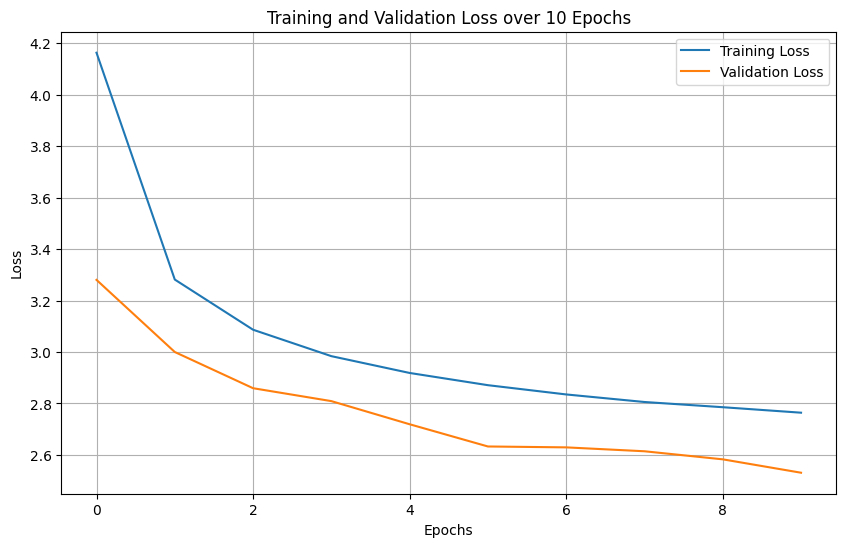

In [ ]:
import matplotlib.pyplot as plt

# Plot training and validation loss over epochs
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss over 10 Epochs')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()


In [ ]:
# Load the best model saved by early stopping
best_model = load_model(random_model_name)

# Save it as the final model after training
best_model.save('final_best_model_after_training.h5')
print("Best model after training saved as 'final_best_model_after_training.h5'")


Best model after training saved as 'final_best_model_after_training.h5'


In [ ]:
from sklearn.model_selection import KFold

# Set number of folds for cross-validation
k_folds = 3

# Create k-fold cross-validator
kf = KFold(n_splits=k_folds, shuffle=True, random_state=42)

# K-fold Cross-validation
fold_val_loss = []

for fold, (train_idx, val_idx) in enumerate(kf.split(train_ids_array)):
    print(f"\nFold {fold+1}/{k_folds}")

    # Split the data into training and validation sets
    train_ids, val_ids = train_ids_array[train_idx], train_ids_array[val_idx]
    train_captions_fold = {img_id: cleaned_captions[img_id] for img_id in train_ids}
    val_captions_fold = {img_id: cleaned_captions[img_id] for img_id in val_ids}
    image_features_train = {img_id: image_features[img_id] for img_id in train_ids}
    image_features_val = {img_id: image_features[img_id] for img_id in val_ids}

    # Compile the best model (if necessary)
    caption_model = load_model('final_best_model_after_training.h5')

    # Steps per epoch for this fold
    steps_per_epoch = len(train_captions_fold) // best_batch_size

    # Train the model for this fold
    history = caption_model.fit(
        data_generator(train_captions_fold, image_features_train, tokenizer, max_length, vocab_size, best_batch_size),
        epochs=1,  # Optionally train for fewer epochs during k-fold cross-validation
        steps_per_epoch=steps_per_epoch,
        validation_data=data_generator(val_captions_fold, image_features_val, tokenizer, max_length, vocab_size, best_batch_size),
        validation_steps=int(steps_per_epoch * 0.08),  # 8% of the training steps used for validation
        verbose=1,
        callbacks=[early_stopping]  # Use EarlyStopping for k-fold cross-validation
    )

    # Get the validation loss for this fold
    fold_val_loss.append(history.history['val_loss'][-1])

# Compute the average validation loss across all folds
avg_val_loss = np.mean(fold_val_loss)
print(f"\nAverage validation loss after k-fold cross-validation: {avg_val_loss}")



Fold 1/3
134/134 [==============================] - 913s 7s/step - loss: 2.7198 - val_loss: 2.7193

Fold 2/3
134/134 [==============================] - 1485s 11s/step - loss: 2.7354 - val_loss: 2.6413

Fold 3/3
134/134 [==============================] - 1435s 11s/step - loss: 2.7278 - val_loss: 2.6685

Average validation loss after k-fold cross-validation: 2.676391919453939


In [ ]:
# Load the final best model after training
best_model = load_model('final_best_model_after_training.h5')

test_ids_array = np.array(test_ids)  # Convert the list to a numpy array

# Prepare the test data generator (assuming test data is similar to training data)
test_captions = {img_id: cleaned_captions[img_id] for img_id in test_ids_array}
test_image_features = {img_id: image_features[img_id] for img_id in test_ids_array}

# Calculate steps_per_epoch for evaluation (just like you would for training)
steps_per_epoch = len(test_captions) // 32  # Adjust 32 if using a different batch size

# Evaluate the final model on the test data
test_loss = best_model.evaluate(
    data_generator(test_captions, test_image_features, tokenizer, max_length, vocab_size, batch_size=32),
    steps=steps_per_epoch,  # Define steps to ensure correct logging
    verbose=1
)

print(f"Test loss: {test_loss}")




50/50 [==============================] - 148s 3s/step - loss: 3.4042
Test loss: 3.404247522354126


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

def beam_search_caption(model, tokenizer, image_feature, max_length, beam_index=3):
    # Start with the start token
    start = [tokenizer.word_index['start']]

    # List of sequences (sequence, score)
    sequences = [[start, 0.0]]

    # Iterate until max length
    while len(sequences[0][0]) < max_length:
        all_candidates = []

        # Expand each current sequence
        for seq, score in sequences:
            # Pad the current sequence
            padded_seq = pad_sequences([seq], maxlen=max_length)

            # Predict the next word probabilities
            yhat = model.predict([np.array([image_feature]), padded_seq], verbose=0)

            # Get top beam_index predictions
            top_indexes = np.argsort(yhat[0])[-beam_index:]

            # Create new sequences with these predictions
            for index in top_indexes:
                word = tokenizer.index_word.get(index)
                if word is None:
                    continue

                # Create new candidate sequence
                new_seq = seq + [index]
                new_score = score - np.log(yhat[0][index])  # log probabilities for better scoring
                all_candidates.append([new_seq, new_score])

        # Order all candidates by score
        sequences = sorted(all_candidates, key=lambda tup: tup[1])

        # Select the top beam_index sequences
        sequences = sequences[:beam_index]

    # Get the best sequence
    best_seq = sequences[0][0]

    # Convert indexes to words, ignoring start/end tokens
    final_caption = [tokenizer.index_word[i] for i in best_seq if i not in [tokenizer.word_index['start'], tokenizer.word_index.get('end')]]

    return ' '.join(final_caption)

In [ ]:
import matplotlib.pyplot as plt
from PIL import Image
import os

def show_image_with_caption(image_id, caption, images_folder):
    # Construct image path
    image_path = os.path.join(images_folder, image_id)

    # Open the image
    img = Image.open(image_path)

    # Plot the image with caption
    plt.imshow(img)
    plt.axis('off')
    plt.title(caption, fontsize=12)
    plt.show()



Image ID: 1776981714_5b224d0f7a.jpg
Generated Caption: a group of people are walking down a city street of


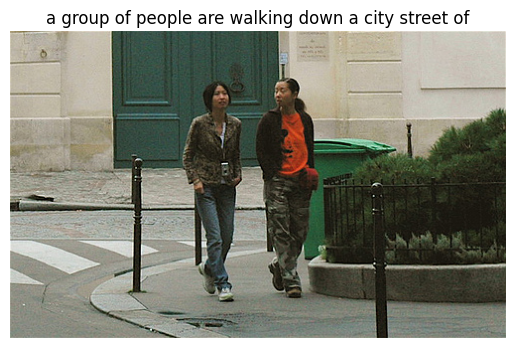


Image ID: 2092870249_90e3f1855b.jpg
Generated Caption: a little boy in a blue shirt and blue jeans plays in the water of a tree of fire of fire


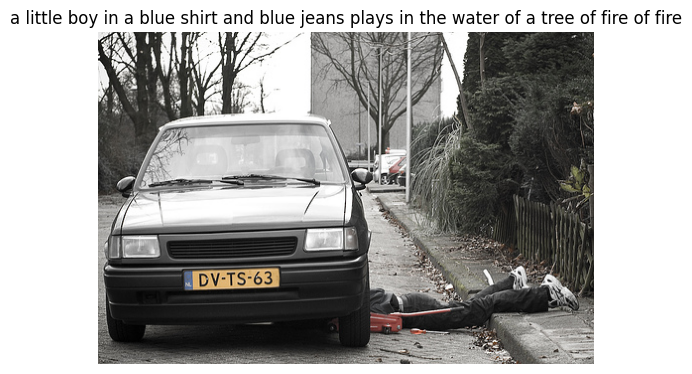


Image ID: 2967630001_cdc5560c0b.jpg
Generated Caption: a surfer is riding a wave in the ocean of the beach of a wave of a snowy mountain of a snowy mountain


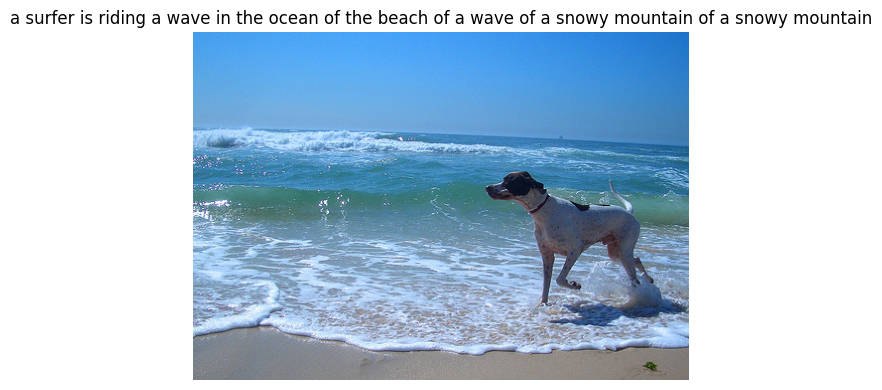


Image ID: 505062117_a70b4e10ab.jpg
Generated Caption: a white dog is running through the water of the ocean of a stream of water


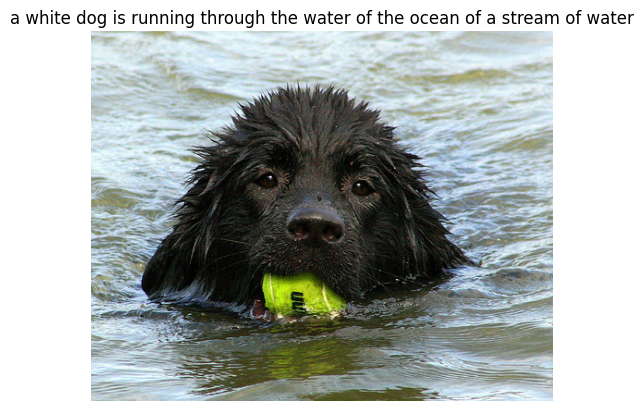


Image ID: 2890057168_c712f932e0.jpg
Generated Caption: a group of people are walking down a city street of


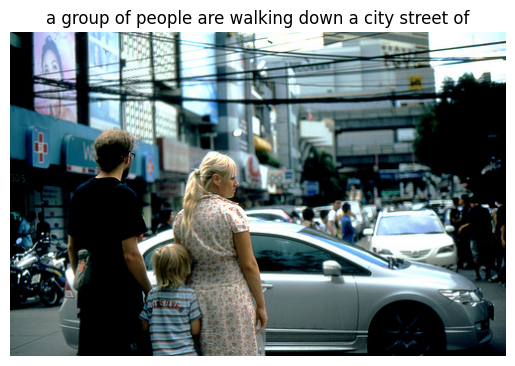

In [ ]:
import random

# Number of images to test
num_test_images = 5

# Pick random image IDs from training or validation set
sample_image_ids = random.sample(test_ids, num_test_images)

# Loop through and generate captions
for image_id in sample_image_ids:
    # Get image feature vector
    image_feature = image_features[image_id]

    # Generate caption
    generated_caption = beam_search_caption(caption_model, tokenizer, image_feature, max_length=38, beam_index=7)


    print(f"\nImage ID: {image_id}")
    print(f"Generated Caption: {generated_caption}")

    # Show the image with its caption
    show_image_with_caption(image_id, generated_caption, images_folder)